### Initializing and Preprocessing the Dataset
#### Reading, Preprocessing and Converting the preprocessed Data into a feature table

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import string

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()

train = pd.read_csv("newsgroup_train.csv")
test = pd.read_csv("newsgroup_test.csv")

def getwntag(tag):
    dictag = {'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV, 'J': wordnet.ADJ}
    return dictag.get(tag[0].upper(), wordnet.NOUN)

def txtprocessing(txt):
    txt = re.sub(r'\d+', '', txt.lower())
    tok = word_tokenize(txt.translate(str.maketrans('', '', string.punctuation)))
    tagtok = pos_tag(tok)
    return [lemmatizer.lemmatize(word, getwntag(tag)) for word, tag in tagtok]

def dataprep(df):
    df['Text'] = df['Text'].fillna('')
    tok = [txtprocessing(entry) for entry in df['Text'].tolist()]
    lbls = df['Label'].tolist()
    vocab = set(word for sen in tok for word in sen)
    return tok, lbls, sorted(vocab)

def featuretable(tokdata, vocabulary):
    vocabmap = {word: j for j, word in enumerate(vocabulary)}
    nsentence = len(tokdata)
    nwords = len(vocabulary)
    ftrs = np.zeros((nsentence, nwords))
    for i in range(nsentence):
        sen = tokdata[i]
        for word in sen:
            j = vocabmap.get(word)
            if j is not None:
                ftrs[i, j] += 1
    return ftrs

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/stu1/s7/sp7289/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/stu1/s7/sp7289/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/stu1/s7/sp7289/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Naive Bayes Algorithm

In [2]:
class SimpleNB:
    def __init__(self, vocabsize):
        self.vsize = vocabsize
        self.priorprob = {}
        self.condprob = {}

    def ft(self, X, y):
        labels = set(y)
        labelc = {label: 0 for label in labels}
        wordc = {label: np.zeros(self.vsize) for label in labels}
        for i in range(len(y)):
            label = y[i]
            labelc[label] += 1
            wordc[label] += X[i]
        totsamples = len(y)
        self.priorprob = {label: np.log2(count / totsamples) for label, count in labelc.items()}
        for label in labels:
            totwords = np.sum(wordc[label])
            self.condprob[label] = np.log2(wordc[label] / totwords)

    def prediction(self, X):
        pred = []
        for sample in X:
            scores = {}
            for label in self.priorprob:
                score = self.priorprob[label]
                for i, count in enumerate(sample):
                    if count > 0:
                        if i < len(self.condprob[label]):
                            score += count * self.condprob[label][i]
                        else:
                            score += count * np.log2(1e-6)
                scores[label] = score
            pred.append(max(scores, key=scores.get))
        return pred

def buildconfmat(actual, predicted, categs):
    nclasses = len(categs)
    mat = np.zeros((nclasses, nclasses), dtype=int)
    idmap = {category: i for i, category in enumerate(categs)}

    for tlabel, plabel in zip(actual, predicted):
        tid = idmap[tlabel]
        pid = idmap[plabel]
        mat[tid, pid] += 1

    return mat


### Naive Bayes Algorithm with Laplace

In [3]:
class LaplaceNB:
    def __init__(self, vsize):
        self.vsize = vsize
        self.priorprob = {}
        self.condprob = {}

    def ft(self, ftrs, lbls):
        setlbl = set(lbls)
        lblcounts = {lbl: 0 for lbl in setlbl}
        tokcounts = {lbl: np.zeros(self.vsize) for lbl in setlbl}
        for i, lbl in enumerate(lbls):
            lblcounts[lbl] += 1
            tokcounts[lbl] += ftrs[i]
        
        docount = len(lbls)
        self.priorprob = {lbl: np.log2(cnt / docount) for lbl, cnt in lblcounts.items()}
        for lbl in setlbl:
            totlbls = np.sum(tokcounts[lbl])
            self.condprob[lbl] = np.log2((tokcounts[lbl] + 1) / (totlbls + self.vsize))

    def prediction(self, ftrset):
        preds = []
        for ftrvector in ftrset:
            scrs = {lbl: self.priorprob[lbl] + np.sum(ftrvector * self.condprob[lbl])
                      for lbl in self.priorprob}
            preds.append(max(scrs, key=scrs.get))
        return preds


### Drawing Heat map for Confusion Matrix

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def HeatMap(mat, lbls, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(mat, annot=True, fmt='d', cmap='coolwarm', xticklabels=lbls, yticklabels=lbls)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.show()


### Visualizing the Performance Metrics

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def vizmetrics(normal_metrics, laplace_metrics):
    categs = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']
    positions = np.arange(len(categs))
    plt.figure(figsize=(10, 6))
    plt.plot(positions, normal_metrics, marker='o', linestyle='-', color='blue', label='Standard Naive Bayes')
    plt.plot(positions, laplace_metrics, marker='s', linestyle='-', color='red', label='Naive Bayes w/ Smoothing')
    plt.xticks(positions, categs)
    plt.ylabel("Scores")
    plt.title("Model Metric Comparison")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


In [6]:
def accuracy(tlbls, plbls):
    correct = sum(1 for true, pred in zip(tlbls, plbls) if true == pred)
    return correct / len(tlbls)

def precision(tlbls, plbls):
    categs = set(tlbls)
    pscores = []
    for c in categs:
        tpos = sum(1 for true, pred in zip(tlbls, plbls) if pred == c and true == c)
        fpos = sum(1 for true, pred in zip(tlbls, plbls) if pred == c and true != c)
        p = tpos / (tpos + fpos) if (tpos + fpos) > 0 else 0
        pscores.append(p)
    return sum(pscores) / len(categs)

def recall(tlbls, plbls):
    categs = set(tlbls)
    rscores = []
    for c in categs:
        tpos = sum(1 for true, pred in zip(tlbls, plbls) if pred == c and true == c)
        fneg = sum(1 for true, pred in zip(tlbls, plbls) if pred != c and true == c)
        r = tpos / (tpos + fneg) if (tpos + fneg) > 0 else 0
        rscores.append(r)
    return sum(rscores) / len(categs)

def f1score(tlbls, plbls):
    p = precision(tlbls, plbls)
    r = recall(tlbls, plbls)
    return (2 * p * r) / (p + r) if (p + r) > 0 else 0

def performance(tlbls, plbls):
    a = accuracy(tlbls, plbls)
    p = precision(tlbls, plbls)
    r = recall(tlbls, plbls)
    f1 = f1score(tlbls, plbls)
    
    print(f"Accuracy: {a:.2f}")
    print(f"Precision (Macro): {p:.2f}")
    print(f"Recall (Macro): {r:.2f}")
    print(f"F1 Score (Macro): {f1:.2f}")
    
    return [a, p, r, f1]


### Naive Bayes With Movie Review Dataset

/tmp/ipykernel_853143/1254429594.py:19: RuntimeWarning: divide by zero encountered in log2
  self.condprob[label] = np.log2(wordc[label] / totwords)


Accuracy: 0.46
Precision (Macro): 0.54
Recall (Macro): 0.39
F1 Score (Macro): 0.45


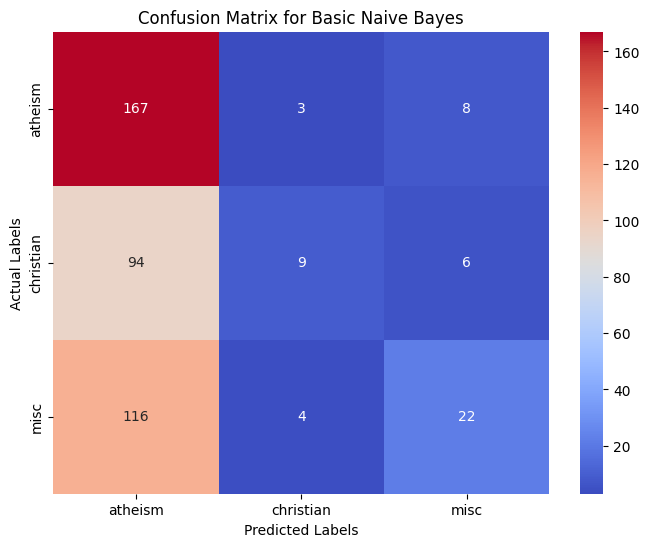

In [7]:
traintok, trainlbls, vocab = dataprep(train)
trainMat = featuretable(traintok, vocab)

nb = SimpleNB(len(vocab))
nb.ft(trainMat, trainlbls)

testtok, testlbls, _ = dataprep(test)
testMat = featuretable(testtok, vocab)

basicpred = nb.prediction(testMat)

basicmet = performance(testlbls, basicpred)
conmatbasic = buildconfmat(testlbls, basicpred, list(set(testlbls)))

HeatMap(conmatbasic, sorted(set(testlbls)), title="Confusion Matrix for Basic Naive Bayes")


### Naive Bayes with Laplace With Movie Review Dataset

Accuracy: 0.64
Precision (Macro): 0.71
Recall (Macro): 0.58
F1 Score (Macro): 0.64


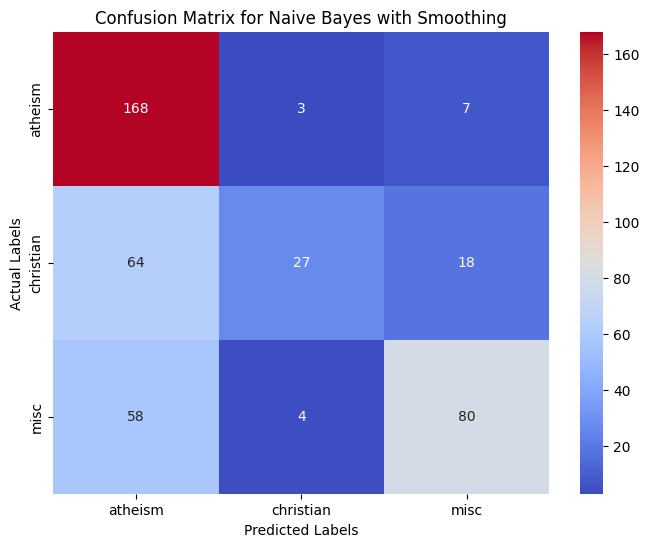

In [8]:
laplace = LaplaceNB(len(vocab))
laplace.ft(trainMat, trainlbls)

laplacepred = laplace.prediction(testMat)

laplacemet = performance(testlbls, laplacepred)
conmatlaplace = buildconfmat(testlbls, laplacepred, list(set(testlbls)))

HeatMap(conmatlaplace, sorted(set(testlbls)), title="Confusion Matrix for Naive Bayes with Smoothing")


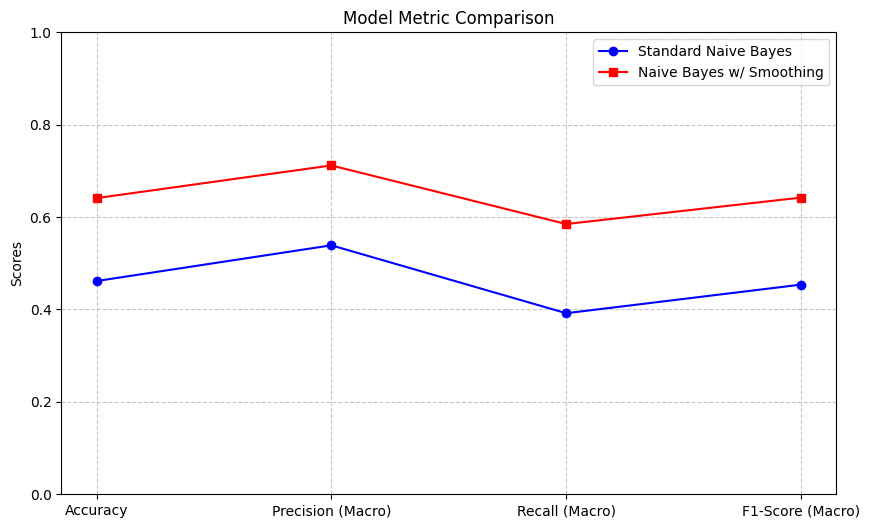

In [9]:
vizmetrics(basicmet, laplacemet)


### News Groups Dataset

In [10]:
train = pd.read_csv("reviews_polarity_train.csv")
test = pd.read_csv("reviews_polarity_test.csv")

### Naive Bayes With News Groups Dataset

/tmp/ipykernel_853143/1254429594.py:19: RuntimeWarning: divide by zero encountered in log2
  self.condprob[label] = np.log2(wordc[label] / totwords)


Accuracy: 0.70
Precision (Macro): 0.71
Recall (Macro): 0.70
F1 Score (Macro): 0.70


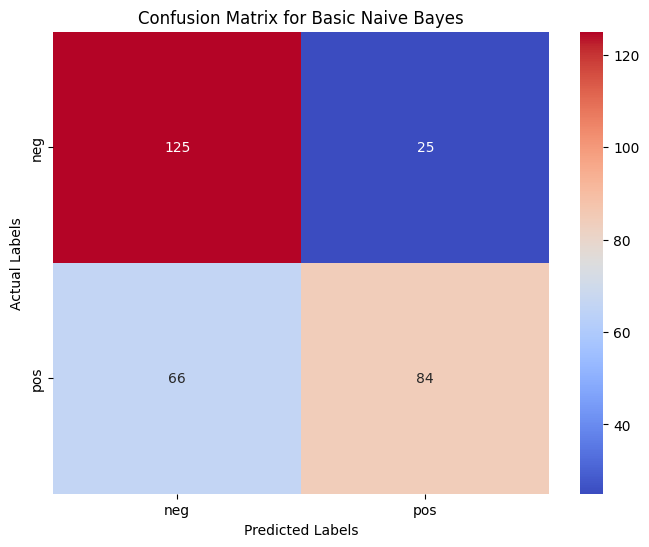

In [11]:
traintok, trainlbls, vocab = dataprep(train)
trainMat = featuretable(traintok, vocab)

nb = SimpleNB(len(vocab))
nb.ft(trainMat, trainlbls)

testtok, testlbls, _ = dataprep(test)
testMat = featuretable(testtok, vocab)

basicpred = nb.prediction(testMat)

basicmet = performance(testlbls, basicpred)
conmatbasic = buildconfmat(testlbls, basicpred, list(set(testlbls)))

HeatMap(conmatbasic, sorted(set(testlbls)), title="Confusion Matrix for Basic Naive Bayes")


### Naive Bayes with Laplace with News Groups Dataset

Accuracy: 0.84
Precision (Macro): 0.84
Recall (Macro): 0.84
F1 Score (Macro): 0.84


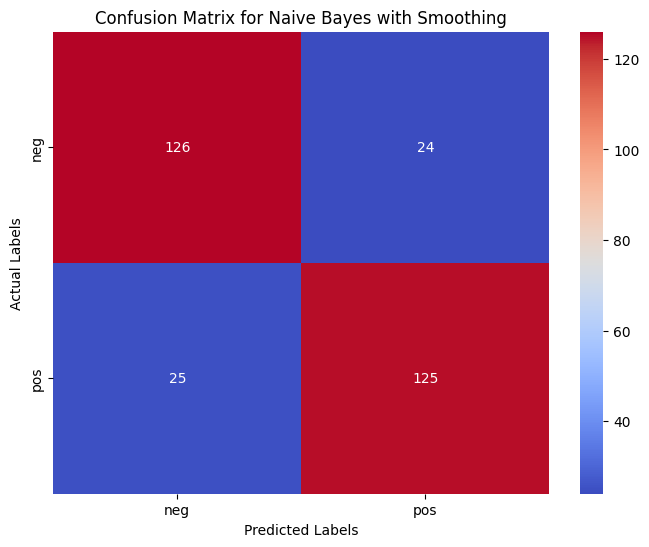

In [12]:
laplace = LaplaceNB(len(vocab))
laplace.ft(trainMat, trainlbls)

laplacepred = laplace.prediction(testMat)

laplacemet = performance(testlbls, laplacepred)
conmatlaplace = buildconfmat(testlbls, laplacepred, list(set(testlbls)))

HeatMap(conmatlaplace, sorted(set(testlbls)), title="Confusion Matrix for Naive Bayes with Smoothing")


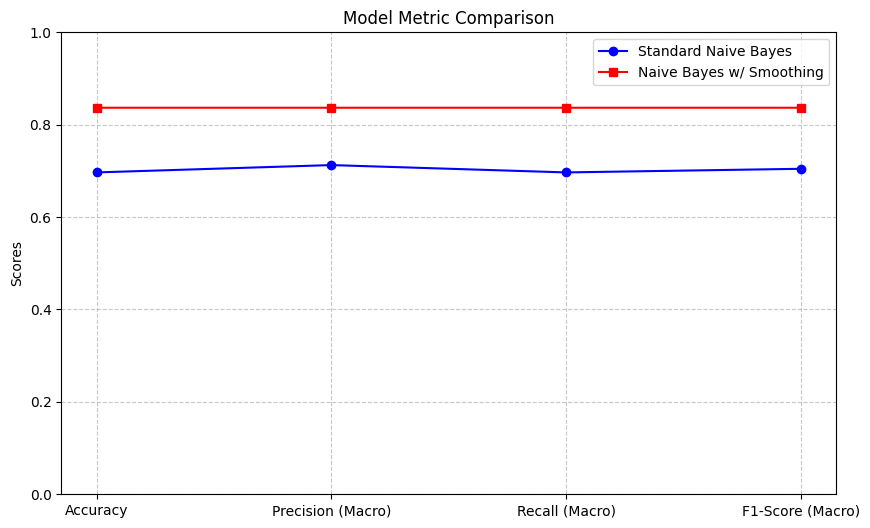

In [13]:
vizmetrics(basicmet, laplacemet)


### Visualizing the Training Dataset

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def dataviz(tokdata, lbls, vocab, train):
    lcount = train['Label'].value_counts()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=lcount.index, y=lcount.values, palette='viridis')
    plt.title('Distribution of Labels in Training Set')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    plt.show()
    
    word_counts = [len(entry) for entry in tokdata]
    plt.figure(figsize=(10, 5))
    sns.histplot(word_counts, bins=30, kde=True)
    plt.title('Word Count Distribution in Training Data')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

    sample_data = train[['Text', 'Label']].sample(5, random_state=42)
    print("Sample Text Data with Labels:")
    print(sample_data)

### Movie Reviews Dataset

/tmp/ipykernel_853143/3106102591.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lcount.index, y=lcount.values, palette='viridis')


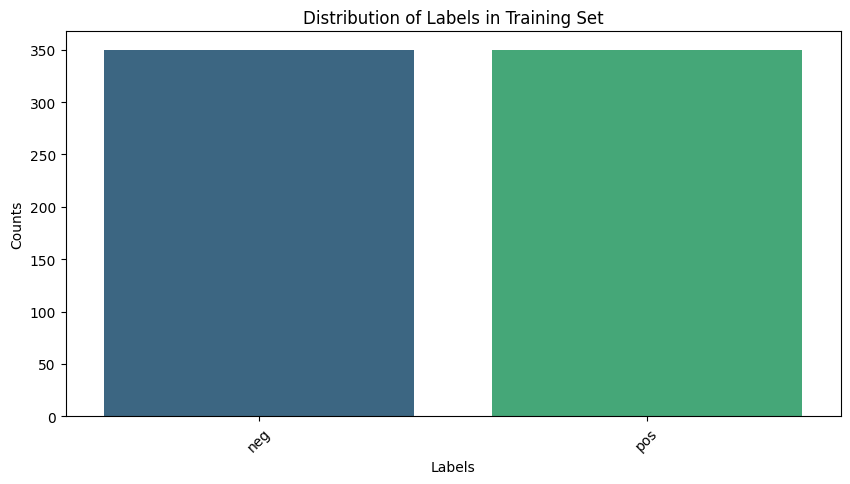

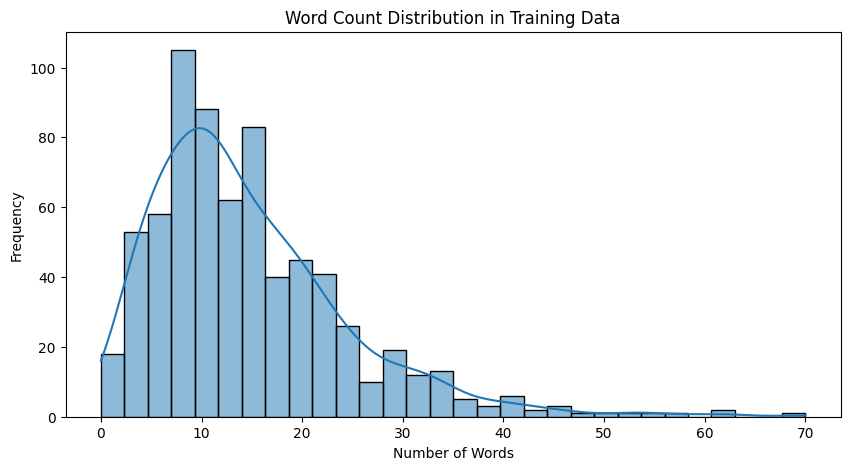

Sample Text Data with Labels:
                                                  Text Label
158  i have seen many movies starring jaclyn smith,...   pos
500          and the accents are absolutely abysmal!     neg
396  the performances are real and gripping, the cr...   pos
155  i'm not sure what he was trying to do with thi...   neg
321  it's too bad that everyone else involved didn'...   neg


In [16]:
train = pd.read_csv(r"reviews_polarity_train.csv")
test = pd.read_csv(r"reviews_polarity_test.csv")
traintok, trainlbls, vocab = dataprep(train)
dataviz(traintok, trainlbls, vocab, train)

### News Groups Dataset

/tmp/ipykernel_853143/3106102591.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lcount.index, y=lcount.values, palette='viridis')


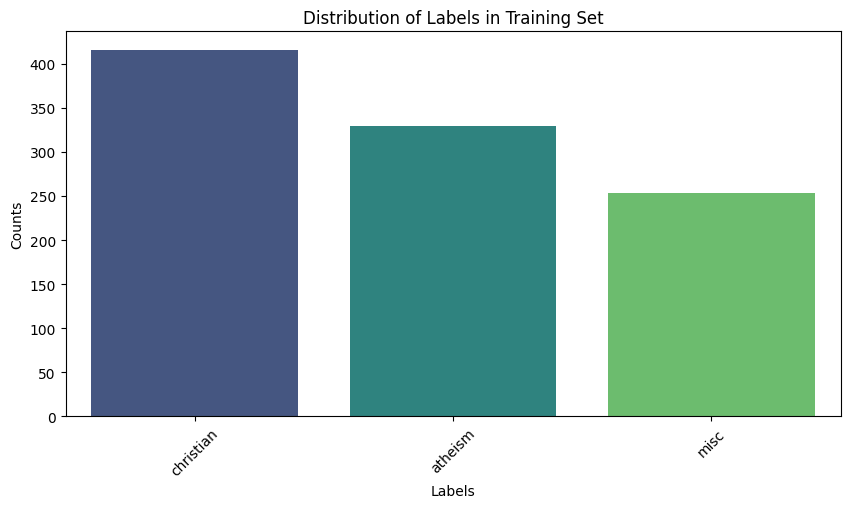

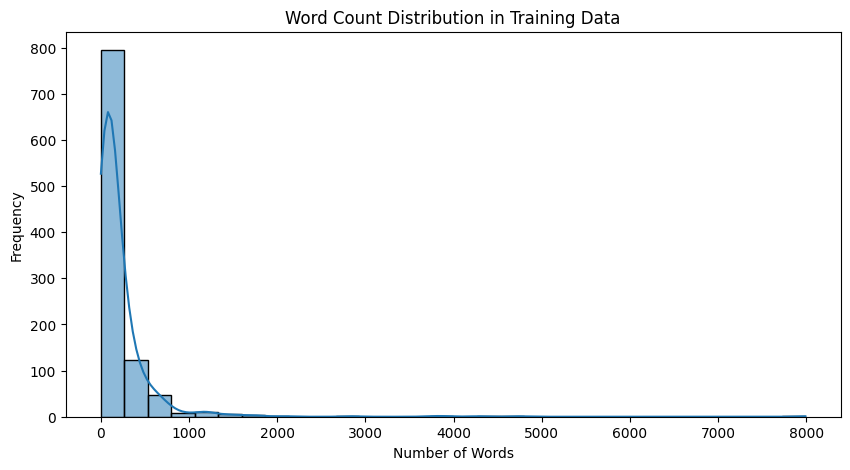

Sample Text Data with Labels:
                                                  Text      Label
521  archivename atheismlogicaltatheismarchivename ...    atheism
737  as i was created in the image of gaea therefor...    atheism
740  no it didnt  the motto has been on various coi...    atheism
660  i have been following this thread on talkrelig...  christian
411  which objective system are you talking about  ...    atheism


In [18]:
train = pd.read_csv(r"newsgroup_train.csv")
test = pd.read_csv(r"newsgroup_test.csv")
traintok, trainlbls, vocab = dataprep(train)
dataviz(traintok, trainlbls, vocab, train)